In [ ]:
# all 60 N=1000 instances generated are chaotic, so the nonchaos observed at N=300 or 500 are finite size effects

In [1]:
from pathlib import Path
import time
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

exec(open("functions28.py").read())

In [2]:
# set basic parameters and subdirectory
part_n_s = jnp.asarray([500, 1000])
part_n_n = part_n_s.shape[0]
e_part_r = 0.8
e_mean = 4
ei_std_s = [2, 8]
interval_len = 900
subdirectory = ("{0:n}-{1:n}_".format(part_n_s[0], part_n_s[-1])
                + "{:n}_".format(e_part_r)
                + "{:n}_".format(e_mean)
                + "{0:n}-{1:n}_".format(ei_std_s[0],
                                        ei_std_s[1])
                + "{:n}/".format(interval_len))
#Path(subdirectory).mkdir()
print(ei_spectral_radius_fct(e_part_r, ei_std_s))

seed = 1695231078#1695156922#1695144903#1695072508#round(time.time())
subdirectory = subdirectory + "{:n}".format(seed) + "/"
#Path(subdirectory).mkdir()
print(subdirectory)

4.0
500-1000_0.8_4_2-8_900/1695231078/


In [3]:
# generate and save parameters for simulation
key = jax.random.PRNGKey(seed)

sub_part_r_s = jnp.asarray([e_part_r, 1 - e_part_r])
sub_part_n_s_s = sub_part_n_s_fct(part_n_s, sub_part_r_s)
unscaled_mean = ei_mean_balancer(sub_part_r_s, e_mean)
unscaled_std = jnp.tile(jnp.asarray([ei_std_s]), (2, 1))
connectivity_n = 15
in_r = 1.
rewiring_prob = 1.
connectivity_s = [0 for part_n in part_n_s]
for part_n_idx in range(part_n_n):
  [connectivity_s[part_n_idx], 
   key] = row_sum_removing_sparsifier(connectivity_s_generator(sub_part_n_s_s[part_n_idx],
                                                               unscaled_mean, unscaled_std,
                                                               connectivity_n,
                                                               key),
                                      sub_part_n_s_s[part_n_idx], in_r, rewiring_prob)
jnp.savez(subdirectory + "parameter_s_1.npz",
          sub_part_r_s, sub_part_n_s_s, unscaled_mean, unscaled_std,
          connectivity_n,
          in_r, rewiring_prob,
          *connectivity_s)

sub_part_n_s_s_ext_gen = sub_part_n_s_fct(part_n_s, jnp.asarray([1]))
ext_part_n_s = part_n_s // 100
ext_sub_part_r_s = jnp.asarray([1.])
ext_sub_part_n_s_s = sub_part_n_s_fct(ext_part_n_s, ext_sub_part_r_s)
unscaled_ext_mean = jnp.asarray([[0.]])
unscaled_ext_std = jnp.asarray([[1.]])
ext_connectivity_n = 3
ext_connectivity_s = [0 for part_n in part_n_s]
for part_n_idx in range(part_n_n):
  [ext_connectivity_s[part_n_idx], 
   key] = ext_connectivity_s_generator(sub_part_n_s_s_ext_gen[part_n_idx], ext_sub_part_n_s_s[part_n_idx],
                                      unscaled_ext_mean, unscaled_ext_std,
                                       ext_connectivity_n,
                                       key)
jnp.savez(subdirectory + "parameter_s_2.npz",
          sub_part_n_s_s_ext_gen, 
          ext_part_n_s, ext_sub_part_r_s,
          ext_sub_part_n_s_s,
          unscaled_ext_mean, unscaled_ext_std, 
          ext_connectivity_n,
          *ext_connectivity_s)

phase_n = 3
phase_s = [0 for part_n in part_n_s]
for part_n_idx in range(part_n_n):
  [phase_s[part_n_idx], key] = phase_s_generator(ext_part_n_s[part_n_idx], phase_n, key)
jnp.savez(subdirectory + "parameter_s_3.npz",
          phase_n,
          *phase_s)

amp_s = jnp.expand_dims(jnp.asarray([0.2, 0.4, 0.8]), 1) # or (wave_n, ext_part_n) arrays so different ext parts have different amps
freq_s = jnp.full(amp_s.shape, 0.)
wave_s = jnp.concatenate([amp_s, freq_s], axis = 1)
wave_n = wave_s.shape[0]
jnp.savez(subdirectory + "parameter_s_4.npz",
          amp_s, freq_s,
          wave_s,
          wave_n)

initial_condition_n = 5
ext_condition_n = ext_connectivity_n * phase_n
initial_condition_n_free = initial_condition_n * ext_condition_n
initial_condition_s = [0 for part_n in part_n_s]
for part_n_idx in range(part_n_n):
  [initial_condition_s[part_n_idx], 
   key] = initial_condition_s_generator(part_n_s[part_n_idx], 
                                        jnp.full((part_n_s[part_n_idx], ), 0), jnp.identity(part_n_s[part_n_idx]), 
                                        initial_condition_n_free, key)
jnp.savez(subdirectory + "parameter_s_5.npz",
          initial_condition_n,
          ext_condition_n, initial_condition_n_free,
          *initial_condition_s)

condition_s = jnp.asarray([1, 1])
condition_s_free = jnp.asarray([0, 0])
time_interval_s = jnp.asarray([[0,300], [300,interval_len]])
jnp.savez(subdirectory + "parameter_s_6.npz",
          condition_s, condition_s_free,
          time_interval_s)
labeled_time_interval_s = [time_interval_s, condition_s]
labeled_time_interval_s_free = [time_interval_s, condition_s_free]

resolution = 24
frame_gap = 24
jnp.savez(subdirectory + "parameter_s_7.npz",
          resolution, frame_gap)

In [3]:
# load parameters
[sub_part_r_s, sub_part_n_s, unscaled_mean, unscaled_std,
 connectivity_n,
 in_r, rewiring_prob,
 *connectivity_s] = load_as_list(subdirectory + "parameter_s_1.npz")

[sub_part_n_s_s_ext_gen, 
 ext_part_n_s, ext_sub_part_r_s,
 ext_sub_part_n_s_s,
 unscaled_ext_mean, unscaled_ext_std, 
 ext_connectivity_n,
 *ext_connectivity_s] = load_as_list(subdirectory + "parameter_s_2.npz")

[phase_n,
 *phase_s] = load_as_list(subdirectory + "parameter_s_3.npz")

[amp_s, freq_s,
 wave_s,
 wave_n] = load_as_list(subdirectory + "parameter_s_4.npz")

[initial_condition_n,
 ext_condition_n, initial_condition_n_free,
 *initial_condition_s] = load_as_list(subdirectory + "parameter_s_5.npz")

[condition_s, condition_s_free,
 time_interval_s] = load_as_list(subdirectory + "parameter_s_6.npz")
labeled_time_interval_s = [time_interval_s, condition_s]
labeled_time_interval_s_free = [time_interval_s, condition_s_free]

[resolution, frame_gap] = load_as_list(subdirectory + "parameter_s_7.npz")

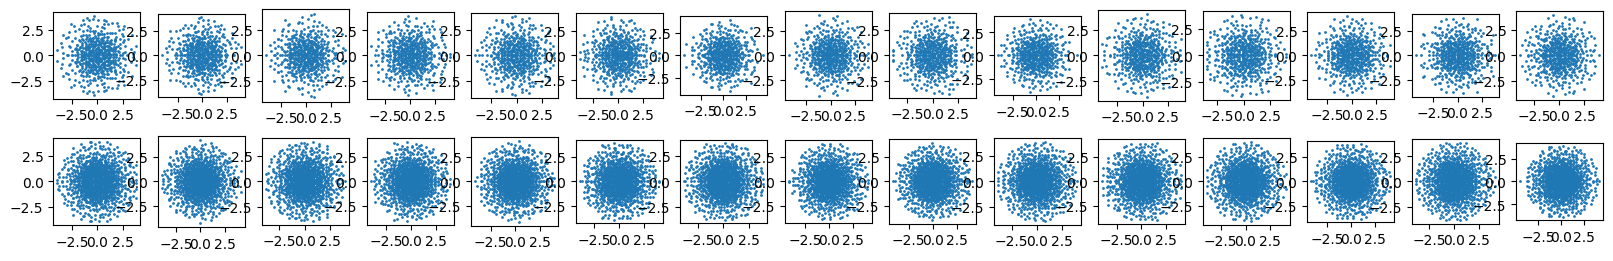

In [4]:
# plot spectra
[fig, subfig_s] = plt.subplots(part_n_n, int(connectivity_n), figsize = (20,3))
for part_n_idx in range(part_n_n):
  for connectivity_idx in range(connectivity_n):
    temp_spectrum = jnp.linalg.eig(connectivity_s[part_n_idx][connectivity_idx])[0]
    subfig_s[part_n_idx, connectivity_idx].plot(jnp.real(temp_spectrum), jnp.imag(temp_spectrum),
                                                linestyle="", marker=".", markersize = 2)
    subfig_s[part_n_idx, connectivity_idx].set_aspect('equal')

In [5]:
# run and save trajs
traj_s_free = [0 for part_n in part_n_s]
for part_n_idx in range(part_n_n):
  traj_s_free[part_n_idx] = low_res_traj_s_fct(connectivity_s[part_n_idx], wave_s[:1], 
                                               ext_connectivity_s[part_n_idx][:1], phase_s[part_n_idx][:1], 
                                               initial_condition_s[part_n_idx],
                                               labeled_time_interval_s_free, resolution, frame_gap)
np.savez_compressed(subdirectory + "trajs_free.npz", *traj_s_free) # jax has not implemented savez_compressed as of 23/08/23

# traj_s = [0 for part_n in part_n_s]
# for part_n_idx in range(part_n_n):
#   traj_s[part_n_idx] = low_res_traj_s_fct(connectivity_s[part_n_idx], wave_s,
#                                           ext_connectivity_s[part_n_idx], phase_s[part_n_idx], 
#                                           initial_condition_s[part_n_idx][::ext_condition_n],
#                                           labeled_time_interval_s, resolution, frame_gap)
# np.savez_compressed(subdirectory + "trajs.npz", *traj_s)

[15, 'connectivity_n']
[1, 'wave_n']
[1, 'ext_connectivity_n']
[1, 'phase_n']
[45, 'initial_condition_n']
0,1.40 mins
1,1.37 mins
2,1.40 mins
3,1.37 mins
4,1.38 mins
5,1.37 mins
6,1.40 mins
7,1.42 mins
8,1.38 mins
9,1.38 mins
10,1.42 mins
11,1.40 mins
12,1.38 mins
13,1.38 mins
14,1.38 mins
[15, 'connectivity_n']
[1, 'wave_n']
[1, 'ext_connectivity_n']
[1, 'phase_n']
[45, 'initial_condition_n']
0,4.73 mins
1,4.77 mins
2,4.77 mins
3,4.80 mins
4,4.85 mins
5,4.77 mins
6,4.78 mins
7,4.82 mins
8,4.88 mins
9,4.88 mins
10,4.88 mins
11,4.88 mins
12,4.90 mins
13,4.87 mins
14,4.92 mins


In [5]:
# load trajs
[*traj_s_free] = load_as_list(subdirectory + "trajs_free.npz")

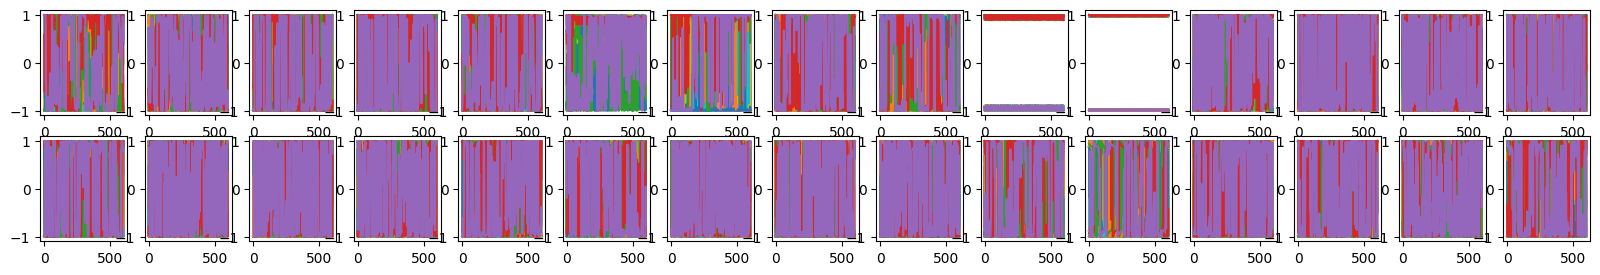

In [6]:
[fig, subfig_s] = plt.subplots(part_n_n, int(connectivity_n), figsize = (20,3))
for part_n_idx in range(part_n_n):
  for connectivity_idx in range(connectivity_n):
    for ic_idx in range(initial_condition_n_free):
      subfig_s[part_n_idx, connectivity_idx].plot(traj_s_free[part_n_idx][connectivity_idx, 0, 0, 0, ic_idx, -15])

(15, 1, 1, 1, 600)
(15, 1, 1, 1, 600)


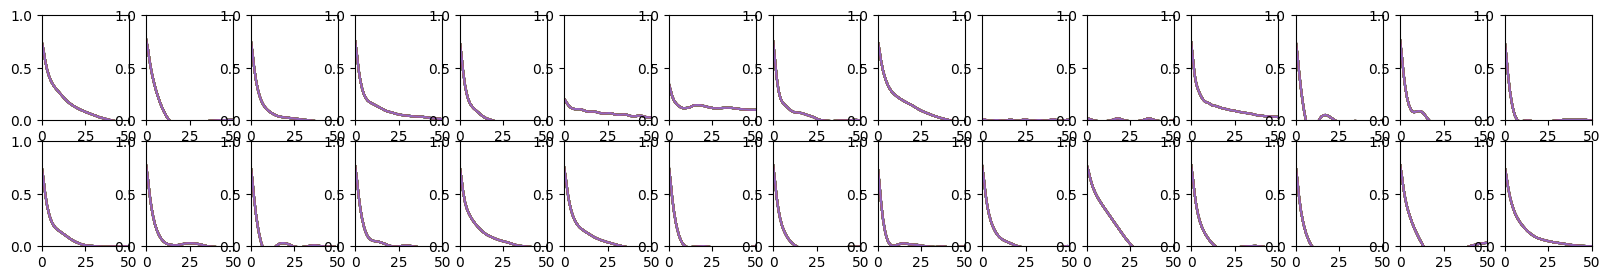

In [7]:
[fig, subfig_s] = plt.subplots(part_n_n, int(connectivity_n), figsize = (20,3))

for part_n_idx in range(part_n_n): 
  mean_s = mean_s_fct(traj_s_free[part_n_idx]) 
  ac_s = jnp.mean(matched_correlation_fct(traj_s_free[part_n_idx], traj_s_free[part_n_idx], mean_s, mean_s), axis = (-3,-2)) 
  print(ac_s.shape) 
  for connectivity_idx in range(connectivity_n): 
    for ic_idx in range(initial_condition_n_free): 
      subfig_s[part_n_idx, connectivity_idx].plot(ac_s[connectivity_idx, 0, 0, 0]) 
      subfig_s[part_n_idx, connectivity_idx].axis(ymin=0,ymax=1,xmin=0,xmax=50)